In [1]:
# The line below sets the environment
# variable CUDA_VISIBLE_DEVICES
get_ipython().magic('env CUDA_VISIBLE_DEVICES =  ')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp      # will come in handy due to the size of the data
import os.path
import random
import time
from collections import OrderedDict
import io
from datetime import datetime
import gc # garbage collector
import sklearn
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import math
import sys
from collections import defaultdict
import re
import logging
from sklearn.model_selection import KFold
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

env: CUDA_VISIBLE_DEVICES=


/home/kapok/pyenv35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kapok/pyenv35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Write a pandas dataframe to disk as gunzip compressed csv
- df.to_csv('dfsavename.csv.gz', compression='gzip')

## Read from disk
- df = pd.read_csv('dfsavename.csv.gz', compression='gzip')

## Magic useful
- %%timeit for the whole cell
- %timeit for the specific line
- %%latex to render the cell as a block of latex
- %prun and %%prun

In [2]:
DATASET_PATH = '/media/rs/0E06CD1706CD0127/Kapok/WSDM/'
HDF_FILENAME = DATASET_PATH + 'datas.h5'
HDF_FILENAME_TEMPSAVE = DATASET_PATH + 'datas_temp.h5'
SUBMISSION_FILENAME = DATASET_PATH + 'submission_{}.csv'
VALIDATION_INDICE = DATASET_PATH + 'validation_indice.csv'

In [3]:
def set_logging(logger_name, logger_file_name):
    log = logging.getLogger(logger_name)
    log.setLevel(logging.DEBUG)

    # create formatter and add it to the handlers
    print_formatter = logging.Formatter('%(message)s')
    file_formatter = logging.Formatter('%(asctime)s - %(name)s_%(levelname)s: %(message)s')

    # create file handler which logs even debug messages
    fh = logging.FileHandler(logger_file_name, mode='w')
    fh.setLevel(logging.DEBUG)
    fh.setFormatter(file_formatter)
    log.addHandler(fh)
    # both output to console and file
    consoleHandler = logging.StreamHandler()
    consoleHandler.setFormatter(print_formatter)
    log.addHandler(consoleHandler)
    
    return log

In [4]:
log = set_logging('MUSIC', DATASET_PATH + 'music_gbm.log')
log.info('here is an info message.')

here is an info message.


In [5]:
store_test = pd.HDFStore(HDF_FILENAME)
test_id =  store_test['test_id']
# train_temp = store_test['train_data'][['registration_init_time', 'expiration_date']]
# test_temp = store_test['test_data'][['registration_init_time', 'expiration_date']]
store_test.close()

In [6]:
gc.collect()

16

In [7]:
# def split_reg_date(input_data):
#     input_data['registration_year'] = input_data['registration_init_time'].apply(lambda x : int(str(x)[0:4]))
#     input_data['registration_year'] = pd.to_numeric(input_data['registration_year'], downcast='unsigned')

#     input_data['registration_month'] = input_data['registration_init_time'].apply(lambda x : int(str(x)[4:6]))
#     input_data['registration_month'] = pd.to_numeric(input_data['registration_month'], downcast='unsigned')

#     input_data['registration_day'] = input_data['registration_init_time'].apply(lambda x : int(str(x)[6:8]))
#     input_data['registration_day'] = pd.to_numeric(input_data['registration_day'], downcast='unsigned')

#     return input_data

In [8]:
# def split_expir_date(input_data):
#     input_data['expiration_year'] = input_data['expiration_date'].apply(lambda x : int(str(x)[0:4]))
#     input_data['expiration_year'] = pd.to_numeric(input_data['expiration_year'], downcast='unsigned')

#     input_data['expiration_month'] = input_data['expiration_date'].apply(lambda x : int(str(x)[4:6]))
#     input_data['expiration_month'] = pd.to_numeric(input_data['expiration_month'], downcast='unsigned')

#     input_data['expiration_day'] = input_data['expiration_date'].apply(lambda x : int(str(x)[6:8]))
#     input_data['expiration_day'] = pd.to_numeric(input_data['expiration_day'], downcast='unsigned')
    
#     return input_data

In [9]:
# train_temp = split_reg_date(train_temp)
# test_temp = split_reg_date(test_temp)
# train_temp = split_expir_date(train_temp)
# test_temp = split_expir_date(test_temp)
# gc.collect()

In [10]:
# x_plays = []
# y_repeat_chance = []#train_data['days'].max()+1
# for i in range(train_temp['registration_year'].min(), train_temp['registration_year'].max()+1):
#     plays_all = train_temp[train_temp['registration_year']==i]
#     #count = plays_all['active_1'].sum()
#     x_plays.append(i)
#     y_repeat_chance.append(len(plays_all))
#     #y_repeat_chance.append(count / (len(plays_all)+1))
# f,axarray = plt.subplots(1,1,figsize=(15,10))
# plt.xlabel('Days')
# plt.ylabel('Chance of repeat listens')
# plt.plot(x_plays, y_repeat_chance)

In [11]:
# x_plays = []
# y_repeat_chance = []#train_data['days'].max()+1
# for i in range(2010, train_temp['expiration_year'].max()+1):
#     plays_all = train_temp[train_temp['expiration_year']==i]
#     #count = plays_all['active_1'].sum()
#     x_plays.append(i)
#     y_repeat_chance.append(len(plays_all))
#     #y_repeat_chance.append(count / (len(plays_all)+1))
# f,axarray = plt.subplots(1,1,figsize=(15,10))
# plt.xlabel('Days')
# plt.ylabel('Chance of repeat listens')
# plt.plot(x_plays, y_repeat_chance)

In [12]:
def date_to_day(input_data):
    # 转换注册时间
    input_data['registration_init_time'] = pd.to_datetime(input_data['registration_init_time'],format="%Y%m%d")
    days = pd.to_datetime('20171111', format='%Y%m%d', errors='ignore') - input_data.registration_init_time
    days = [d.days for d in days]
    input_data['days_before_now']=days
    
    return input_data

In [13]:
# train_temp = date_to_day(train_temp)
# validation_temp = train_temp.iloc[list(range(7277417, 7377417))].copy(deep=True).reset_index(drop=True)
# #train_use = train.drop(validation_list)
# train_temp = train_temp.drop(list(range(7277417, 7377417)))
# test_temp = date_to_day(test_temp)
# gc.collect()

In [14]:
# del train_use, validation_use, test
gc.collect()
float32_list = ['genre_ids', 'language', 'song_year', 'composer_score', 'lyricist_score', 'artist_name_score', 'popular_0', 'num_people_0', 'popular_1', 'popular_2', 'popular_3', 'popular_4', 'active_0', 'num_song_0', 'active_1', 'active_2', 'active_3', 'active_4', 'song_id_by_city', 'msno_by_country', 'msno_by_language', 'genre_ids_score', 'msno_is_in_topK_of_artist_name', 'msno_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_msno', 'source_screen_name_count', 'source_type_count', 'source_system_tab_count', 'source_screen_name_avg_score', 'source_type_avg_score', 'source_system_tab_avg_score', 'composer_by_city_country_language', 'lyricist_by_city_country_language', 'artist_name_by_city_country_language', 'city_hot', 'language_hot']
data_type_map =dict(zip(float32_list, [np.float32]*len(float32_list))) 
train_use = pd.read_csv(DATASET_PATH + 'temp_train_all_comp_encode_id.csv', compression='gzip', dtype = data_type_map)
gc.collect()
validation_use = pd.read_csv(DATASET_PATH + 'temp_validation_all_comp_encode_id.csv', compression='gzip', dtype = data_type_map)
test = pd.read_csv(DATASET_PATH + 'temp_test_all_comp_encode_id.csv', compression='gzip', dtype = data_type_map)
#test_id =  test['id']
gc.collect()

0

In [15]:
# gc.collect()
# float32_list = ['logits_0', 'logits_1', 'logits_2', 'logits_3']
# data_type_map =dict(zip(float32_list, [np.float32]*len(float32_list))) 
# train_use_logits = pd.read_csv(DATASET_PATH + 'msno_artist_logits_train.csv', compression='gzip', dtype = data_type_map)
# gc.collect()
# validation_use_logits = pd.read_csv(DATASET_PATH + 'msno_artist_logits_val.csv', compression='gzip', dtype = data_type_map)
# test_logits = pd.read_csv(DATASET_PATH + 'msno_artist_logits_test.csv', compression='gzip', dtype = data_type_map)
# gc.collect()

In [16]:
# train_use = pd.concat([train_use, train_use_logits], axis=1, join="outer")
# gc.collect()
# validation_use = pd.concat([validation_use, validation_use_logits], axis=1, join="outer")
# test = pd.concat([test, test_logits], axis=1, join="outer")
# gc.collect()
# #print(test.head())

In [17]:
# print(train_use[['msno', 'artist_name']].head())

In [18]:
# train_use[['msno', 'artist_name']].to_csv(DATASET_PATH + 'msno_artist_train.csv', index = False, compression='gzip')
# print('train saved.')
# validation_use[['msno', 'artist_name']].to_csv(DATASET_PATH + 'msno_artist_val.csv', index = False, compression='gzip')
# print('val saved.')
# test[['msno', 'artist_name']].to_csv(DATASET_PATH + 'msno_artist_test.csv', index = False, compression='gzip')
# print('test saved.')

In [19]:
# train_use = pd.concat([train_use, train_temp[['days_before_now']]], axis=1)
# validation_use = pd.concat([validation_use, validation_temp[['days_before_now']]], axis=1)
# test = pd.concat([test, test_temp[['days_before_now']]], axis=1)
# gc.collect()

In [20]:
def catogory_encode_transform(train_data, val_data, test_data, col):
    gc.collect()
    temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")
    gc.collect()
    all_values = list(temp_data[col].unique())
    gc.collect()
    map_dict = dict(zip(all_values, [i for i in range(len(all_values))]))
    gc.collect()
#     train_data[col] = train_data[col].map(map_dict)
#     val_data[col] = val_data[col].map(map_dict)
#     test_data[col] = test_data[col].map(map_dict)
    return train_data[col].map(map_dict), val_data[col].map(map_dict), test_data[col].map(map_dict)

In [21]:
for col in ['msno_is_in_topK_of_artist_name', 'msno_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_msno']:
    train_use[col] = train_use[col].astype('category')
    validation_use[col] = validation_use[col].astype('category')
    test[col] = test[col].astype('category')
    train_use[[col]], validation_use[[col]], test[[col]] = catogory_encode_transform(train_use[[col]], validation_use[[col]], test[[col]], col)
    gc.collect()

In [22]:
# col = 'msno'
# train_use[[col]], validation_use[[col]], test[[col]] = catogory_encode_transform(train_use[[col]], validation_use[[col]], test[[col]], col)
# gc.collect()
# col = 'song_id'
# train_use[[col]], validation_use[[col]], test[[col]] = catogory_encode_transform(train_use[[col]], validation_use[[col]], test[[col]], col)
# gc.collect()
# col = 'name'
# train_use[[col]], validation_use[[col]], test[[col]] = catogory_encode_transform(train_use[[col]], validation_use[[col]], test[[col]], col)
# gc.collect()
# col = 'composer'
# train_use[[col]], validation_use[[col]], test[[col]] = catogory_encode_transform(train_use[[col]], validation_use[[col]], test[[col]], col)
# gc.collect()
# col = 'lyricist'
# train_use[[col]], validation_use[[col]], test[[col]] = catogory_encode_transform(train_use[[col]], validation_use[[col]], test[[col]], col)
# gc.collect()
# col = 'artist_name'
# train_use[[col]], validation_use[[col]], test[[col]] = catogory_encode_transform(train_use[[col]], validation_use[[col]], test[[col]], col)
# gc.collect()


for col in ['source_system_tab', 'source_screen_name', 'source_type', 'country']:
    train_use[[col]], validation_use[[col]], test[[col]] = catogory_encode_transform(train_use[[col]], validation_use[[col]], test[[col]], col)
    gc.collect()

In [23]:
# for col in test.columns:
#     if col in ['language', 'genre_ids', 'song_year']:
#         train_use[col] = train_use[col].astype(np.int32)
#         validation_use[col] = validation_use[col].astype(np.int32)
#         test[col] = test[col].astype(np.int32)

In [24]:
for col in test.columns:
    if col not in ['song_length', 'id']:
        if test[col].dtype == np.float64:
            train_use[col] = train_use[col].astype(np.float32)
            validation_use[col] = validation_use[col].astype(np.float32)
            test[col] = test[col].astype(np.float32)

In [25]:
# for col in ['msno', 'song_id', 'name', 'composer', 'lyricist', 'artist_name']:
#     train_use[col] = train_use[col].astype('category')
#     validation_use[col] = validation_use[col].astype('category')
#     test[col] = test[col].astype('category')
# for col in ['msno', 'song_id', 'name', 'composer', 'lyricist', 'artist_name']:
#     train_use[col] = train_use[col].astype('category')
#     validation_use[col] = validation_use[col].astype('category')
#     test[col] = test[col].astype('category')
# for col in ['artist_name']:
#     train_use[col] = train_use[col].astype('category')
#     validation_use[col] = validation_use[col].astype('category')
#     test[col] = test[col].astype('category')

In [26]:
for col in [col for col in test.columns if col != 'id' ]:
    if train_use[col].dtype == object:
        train_use[col] = train_use[col].astype('category')
        validation_use[col] = validation_use[col].astype('category')
        test[col] = test[col].astype('category')

In [27]:
for col in test.columns:
    if col in ['registered_via', 'bd', 'city', 'registration_year', 'registration_month', 'registration_day', 'expiration_year', 'expiration_year', 'expiration_day']:
        if test[col].dtype == np.int64:
            train_use[col] = train_use[col].astype(np.int32)
            validation_use[col] = validation_use[col].astype(np.int32)
            test[col] = test[col].astype(np.int32)

In [28]:
# float32_list = list()
# for col in test.columns:
#     if col not in ['song_length', 'id']:
#         if test[col].dtype == np.float32:
#             float32_list.append(col)
# print(float32_list)

In [29]:
# train_use.to_csv(DATASET_PATH + 'temp_train_all_comp_encode_id.csv', index = False, compression='gzip')
# print('train saved.')
# validation_use.to_csv(DATASET_PATH + 'temp_validation_all_comp_encode_id.csv', index = False, compression='gzip')
# print('val saved.')
# test.to_csv(DATASET_PATH + 'temp_test_all_comp_encode_id.csv', index = False, compression='gzip')
# print('test saved.')

In [30]:
def new_artistname_related(train_data, val_data, test_data):
    gc.collect()
    temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")

    temp_data['avg_active_per_msno'] = temp_data[['active_1', 'active_2', 'active_3', 'active_4']].mean(axis = 1).astype(np.float32)
    
    grouped = temp_data[['msno', 'artist_name']].groupby(['artist_name'])
    
    num_people_per_artist = grouped['msno'].agg(lambda x: x.nunique())
    num_people_per_artist = num_people_per_artist.reset_index()
    num_people_per_artist.columns = ['artist_name', 'num_people_per_artist']
    #print(num_people_per_artist)
    mean_people_active_per_artist = temp_data[['artist_name', 'avg_active_per_msno']].groupby(['artist_name'])['avg_active_per_msno'].agg('mean')
    mean_people_active_per_artist = mean_people_active_per_artist.reset_index()
    mean_people_active_per_artist.columns = ['artist_name', 'mean_people_active_per_artist']
    #print(sum_people_active_per_artist)
    train_data = train_data.merge(right = num_people_per_artist, how = 'left', on='artist_name')
    val_data = val_data.merge(right = num_people_per_artist, how = 'left', on='artist_name')
    test_data = test_data.merge(right = num_people_per_artist, how = 'left', on='artist_name')
    
    train_data = train_data.merge(right = mean_people_active_per_artist, how = 'left', on='artist_name')
    val_data = val_data.merge(right = mean_people_active_per_artist, how = 'left', on='artist_name')
    test_data = test_data.merge(right = mean_people_active_per_artist, how = 'left', on='artist_name')
    
    return train_data[['num_people_per_artist', 'mean_people_active_per_artist']], val_data[['num_people_per_artist', 'mean_people_active_per_artist']], test_data[['num_people_per_artist', 'mean_people_active_per_artist']]
  

In [31]:
gc.collect()
train_use[['num_people_per_artist', 'mean_people_active_per_artist']], \
validation_use[['num_people_per_artist', 'mean_people_active_per_artist']], \
test[['num_people_per_artist', 'mean_people_active_per_artist']] = new_artistname_related(train_use[['artist_name', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
                                                                                         validation_use[['artist_name', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
                                                                                         test[['artist_name', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']])

gc.collect()

228

In [32]:
time_wnd = [2018, 0, 2000, 2010, 2014, 2018]
def cal_artist_popular(train_data, val_data, test_data):
    all_data = pd.concat([train_data[['artist_name', 'song_year']], val_data[['artist_name', 'song_year']], test_data[['artist_name', 'song_year']]], axis=0, join="inner")

    for index, _ in enumerate(time_wnd[:-1]):
        begin_time, end_time = time_wnd[index] < time_wnd[index+1] and (time_wnd[index], time_wnd[index+1]) or (time_wnd[index+1], time_wnd[index])
        
        select_data = all_data[all_data['song_year'].map(lambda x: x>=begin_time and x < end_time)]

        grouped = select_data[['artist_name']].groupby(['artist_name'])

        count_artist_name = grouped['artist_name'].agg(['count'])

        popularity = pd.concat([np.log(count_artist_name+1)], axis=1, join="inner")
        popularity.columns = ['artist_popular_{}'.format(index)]
        popularity = popularity.reset_index(drop=False)
        train_data = train_data.merge(popularity, on='artist_name', how ='left')
        test_data = test_data.merge(popularity, on='artist_name', how ='left')
        val_data = val_data.merge(popularity, on='artist_name', how ='left')
    return_list = list()
    for index, _ in enumerate(time_wnd[:-1]):
        return_list.append('artist_popular_{}'.format(index))
 
    return train_data[return_list], val_data[return_list], test_data[return_list]

return_list = ['artist_popular_0', 'artist_popular_1', 'artist_popular_2', 'artist_popular_3', 'artist_popular_4']
input_list = ['artist_name', 'song_year']
gc.collect()
train_use[return_list], validation_use[return_list], test[return_list] = cal_artist_popular(train_use[input_list], validation_use[input_list], test[input_list])
gc.collect()

439

In [33]:
def new_msno_related(train_data, val_data, test_data):
    gc.collect()
    temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")

    temp_data['avg_popular_per_artist'] = temp_data[['artist_popular_1', 'artist_popular_2', 'artist_popular_3', 'artist_popular_4']].mean(axis = 1).astype(np.float32)
    
    grouped = temp_data[['msno', 'artist_name']].groupby(['msno'])
    
    num_artist_per_people = grouped['artist_name'].agg(lambda x: x.nunique())
    num_artist_per_people = num_artist_per_people.reset_index()
    num_artist_per_people.columns = ['msno', 'num_artist_per_people']
    #print(num_people_per_artist)
    mean_artist_popular_per_people = temp_data[['msno', 'avg_popular_per_artist']].groupby(['msno'])['avg_popular_per_artist'].agg('mean')
    mean_artist_popular_per_people = mean_artist_popular_per_people.reset_index()
    mean_artist_popular_per_people.columns = ['msno', 'mean_artist_popular_per_people']
    #print(sum_people_active_per_artist)
    train_data = train_data.merge(right = num_artist_per_people, how = 'left', on='msno')
    val_data = val_data.merge(right = num_artist_per_people, how = 'left', on='msno')
    test_data = test_data.merge(right = num_artist_per_people, how = 'left', on='msno')
    
    train_data = train_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
    val_data = val_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
    test_data = test_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
    
    return train_data[['num_artist_per_people', 'mean_artist_popular_per_people']], val_data[['num_artist_per_people', 'mean_artist_popular_per_people']], test_data[['num_artist_per_people', 'mean_artist_popular_per_people']]
gc.collect()
train_use[['num_artist_per_people', 'mean_artist_popular_per_people']], \
validation_use[['num_artist_per_people', 'mean_artist_popular_per_people']], \
test[['num_artist_per_people', 'mean_artist_popular_per_people']] = new_msno_related(train_use[['artist_name', 'msno', 'artist_popular_1', 'artist_popular_2', 'artist_popular_3', 'artist_popular_4']], \
                                                                                         validation_use[['artist_name', 'msno', 'artist_popular_1', 'artist_popular_2', 'artist_popular_3', 'artist_popular_4']], \
                                                                                         test[['artist_name', 'msno','artist_popular_1', 'artist_popular_2', 'artist_popular_3', 'artist_popular_4']])

gc.collect() 

208

In [34]:
def song_msno_related(train_data, val_data, test_data):
    gc.collect()
    temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")

    temp_data['avg_popular_per_song_id'] = temp_data[['popular_1', 'popular_2', 'popular_3', 'popular_4']].mean(axis = 1).astype(np.float32)
    
    grouped = temp_data[['msno', 'song_id']].groupby(['msno'])
    
    num_artist_per_people = grouped['song_id'].agg(lambda x: x.nunique())
    num_artist_per_people = num_artist_per_people.reset_index()
    num_artist_per_people.columns = ['msno', 'num_songs_per_people']
    #print(num_people_per_artist)
    mean_artist_popular_per_people = temp_data[['msno', 'avg_popular_per_song_id']].groupby(['msno'])['avg_popular_per_song_id'].agg('mean')
    mean_artist_popular_per_people = mean_artist_popular_per_people.reset_index()
    mean_artist_popular_per_people.columns = ['msno', 'mean_song_popular_per_people']
    #print(sum_people_active_per_artist)
    train_data = train_data.merge(right = num_artist_per_people, how = 'left', on='msno')
    val_data = val_data.merge(right = num_artist_per_people, how = 'left', on='msno')
    test_data = test_data.merge(right = num_artist_per_people, how = 'left', on='msno')
    
    train_data = train_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
    val_data = val_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
    test_data = test_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
    
    return train_data[['num_songs_per_people', 'mean_song_popular_per_people']], val_data[['num_songs_per_people', 'mean_song_popular_per_people']], test_data[['num_songs_per_people', 'mean_song_popular_per_people']]
gc.collect()
train_use[['num_songs_per_people', 'mean_song_popular_per_people']], \
validation_use[['num_songs_per_people', 'mean_song_popular_per_people']], \
test[['num_songs_per_people', 'mean_song_popular_per_people']] = song_msno_related(train_use[['song_id', 'msno', 'popular_1', 'popular_2', 'popular_3', 'popular_4']], \
                                                                                         validation_use[['song_id', 'msno', 'popular_1', 'popular_2', 'popular_3', 'popular_4']], \
                                                                                         test[['song_id', 'msno', 'popular_1', 'popular_2', 'popular_3', 'popular_4']])

gc.collect() 

193

In [35]:
def days_msno_related(train_data, val_data, test_data):
    gc.collect()
    temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")

    temp_data['days'] = temp_data['days'].apply(lambda x : int(x/15) if x > 0 else 0)
    
    temp_data['avg_active_per_msno'] = temp_data[['active_1', 'active_2', 'active_3', 'active_4']].mean(axis = 1).astype(np.float32)
    
    grouped = temp_data[['msno', 'days']].groupby(['days'])
    
    num_artist_per_people = grouped['msno'].agg(lambda x: x.nunique())
    num_artist_per_people = num_artist_per_people.reset_index()
    num_artist_per_people.columns = ['days', 'num_msno_per_day']
    #print(num_people_per_artist)
    mean_artist_popular_per_people = temp_data[['days', 'avg_active_per_msno']].groupby(['days'])['avg_active_per_msno'].agg('mean')
    mean_artist_popular_per_people = mean_artist_popular_per_people.reset_index()
    mean_artist_popular_per_people.columns = ['days', 'mean_active_per_day']
    #print(sum_people_active_per_artist)
    train_data = train_data.merge(right = num_artist_per_people, how = 'left', on='days')
    val_data = val_data.merge(right = num_artist_per_people, how = 'left', on='days')
    test_data = test_data.merge(right = num_artist_per_people, how = 'left', on='days')
    
    train_data = train_data.merge(right = mean_artist_popular_per_people, how = 'left', on='days')
    val_data = val_data.merge(right = mean_artist_popular_per_people, how = 'left', on='days')
    test_data = test_data.merge(right = mean_artist_popular_per_people, how = 'left', on='days')
    
    return train_data[['num_msno_per_day', 'mean_active_per_day']], val_data[['num_msno_per_day', 'mean_active_per_day']], test_data[['num_msno_per_day', 'mean_active_per_day']]
gc.collect()
train_use[['num_msno_per_day', 'mean_active_per_day']], \
validation_use[['num_msno_per_day', 'mean_active_per_day']], \
test[['num_msno_per_day', 'mean_active_per_day']] = days_msno_related(train_use[['days', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
                                                                                         validation_use[['days', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
                                                                                         test[['days', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']])

gc.collect() 

206

In [36]:
# def bd_log(train_data, val_data, test_data):
#     gc.collect()
#     train_data['bd'] = np.log(train_data['bd']+1)
#     val_data['bd'] = np.log(val_data['bd']+1)
#     test_data['bd'] = np.log(test_data['bd']+1)
    
#     return train_data[['bd']], val_data[['bd']], test_data[['bd']]
# gc.collect()
# train_use[['bd']], validation_use[['bd']], test[['bd']] = bd_log(train_use[['bd']], validation_use[['bd']], test[['bd']])

# gc.collect() 

In [37]:
def bd_msno_related(train_data, val_data, test_data):
    gc.collect()
    temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")

    #temp_data['bd'] = temp_data['bd'].apply(lambda x : int(x) if x > 0 else 0)
    temp_data['bd'] = temp_data['bd'].apply(lambda x : int(x/3) if x > 0 else 0)
    
    temp_data['avg_active_per_msno'] = temp_data[['active_1', 'active_2', 'active_3', 'active_4']].mean(axis = 1).astype(np.float32)
    
    grouped = temp_data[['msno', 'bd']].groupby(['bd'])
    
    num_artist_per_people = grouped['msno'].agg(lambda x: x.nunique())
    num_artist_per_people = num_artist_per_people.reset_index()
    num_artist_per_people.columns = ['bd', 'num_msno_per_bd']
    #print(num_people_per_artist)
    mean_artist_popular_per_people = temp_data[['bd', 'avg_active_per_msno']].groupby(['bd'])['avg_active_per_msno'].agg('mean')
    mean_artist_popular_per_people = mean_artist_popular_per_people.reset_index()
    mean_artist_popular_per_people.columns = ['bd', 'mean_active_per_bd']
    #print(sum_people_active_per_artist)
    train_data = train_data.merge(right = num_artist_per_people, how = 'left', on='bd')
    val_data = val_data.merge(right = num_artist_per_people, how = 'left', on='bd')
    test_data = test_data.merge(right = num_artist_per_people, how = 'left', on='bd')
    
    train_data = train_data.merge(right = mean_artist_popular_per_people, how = 'left', on='bd')
    val_data = val_data.merge(right = mean_artist_popular_per_people, how = 'left', on='bd')
    test_data = test_data.merge(right = mean_artist_popular_per_people, how = 'left', on='bd')
    
    return train_data[['num_msno_per_bd', 'mean_active_per_bd']], val_data[['num_msno_per_bd', 'mean_active_per_bd']], test_data[['num_msno_per_bd', 'mean_active_per_bd']]
gc.collect()
train_use[['num_msno_per_bd', 'mean_active_per_bd']], \
validation_use[['num_msno_per_bd', 'mean_active_per_bd']], \
test[['num_msno_per_bd', 'mean_active_per_bd']] = bd_msno_related(train_use[['bd', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
                                                                                         validation_use[['bd', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
                                                                                         test[['bd', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']])

gc.collect() 

229

In [38]:
def bd_msno_related(train_data, val_data, test_data):
    gc.collect()
    temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")

    #temp_data['bd'] = temp_data['bd'].apply(lambda x : int(x) if x > 0 else 0)
    temp_data['bd'] = temp_data['bd'].apply(lambda x : int(x/3) if x > 0 else 0)
    
    temp_data['avg_active_per_msno'] = temp_data[['active_1', 'active_2', 'active_3', 'active_4']].mean(axis = 1).astype(np.float32)
    
    grouped = temp_data[['msno', 'bd']].groupby(['bd'])
    
    num_artist_per_people = grouped['msno'].agg(lambda x: x.nunique())
    num_artist_per_people = num_artist_per_people.reset_index()
    num_artist_per_people.columns = ['bd', 'num_msno_per_bd']
    #print(num_people_per_artist)
    mean_artist_popular_per_people = temp_data[['bd', 'avg_active_per_msno']].groupby(['bd'])['avg_active_per_msno'].agg('mean')
    mean_artist_popular_per_people = mean_artist_popular_per_people.reset_index()
    mean_artist_popular_per_people.columns = ['bd', 'mean_active_per_bd']
    #print(sum_people_active_per_artist)
    train_data = train_data.merge(right = num_artist_per_people, how = 'left', on='bd')
    val_data = val_data.merge(right = num_artist_per_people, how = 'left', on='bd')
    test_data = test_data.merge(right = num_artist_per_people, how = 'left', on='bd')
    
    train_data = train_data.merge(right = mean_artist_popular_per_people, how = 'left', on='bd')
    val_data = val_data.merge(right = mean_artist_popular_per_people, how = 'left', on='bd')
    test_data = test_data.merge(right = mean_artist_popular_per_people, how = 'left', on='bd')
    
    return train_data[['num_msno_per_bd', 'mean_active_per_bd']], val_data[['num_msno_per_bd', 'mean_active_per_bd']], test_data[['num_msno_per_bd', 'mean_active_per_bd']]
gc.collect()
train_use[['num_msno_per_bd', 'mean_active_per_bd']], \
validation_use[['num_msno_per_bd', 'mean_active_per_bd']], \
test[['num_msno_per_bd', 'mean_active_per_bd']] = bd_msno_related(train_use[['bd', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
                                                                                         validation_use[['bd', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
                                                                                         test[['bd', 'msno', 'active_1', 'active_2', 'active_3', 'active_4']])

gc.collect() 

187

In [39]:
# def weight_source_type_for_each_msno(train_data, val_data, test_data):

#     temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")

#     temp_group = temp_data.groupby(['msno', 'source_screen_name'])
#     type_count = temp_group['source_screen_name'].agg(['count'])
#     type_count = type_count.reset_index()
#     type_count.columns = ['msno', 'source_screen_name', 'source_screen_name_count']

#     #print(type_count)

#     type_count = type_count.merge(type_count.groupby(['msno'])['source_screen_name_count'].agg(['sum']).reset_index(),  how='left', on='msno')
#     type_count.columns = ['msno', 'source_screen_name', 'source_screen_name_count', 'source_screen_name_sum']
#     type_count['weight_source_type_per_msno'] = type_count['source_screen_name_count'] / type_count['source_screen_name_sum']

#     type_count.drop(['source_screen_name_count', 'source_screen_name_sum'], axis = 1, inplace=True)


#     type_count = type_count.merge(type_count.groupby(['msno'])['weight_source_type_per_msno'].agg(['max']).reset_index(),  how='left', on='msno')
#     type_count.columns = ['msno', 'source_screen_name', 'weight_source_type_per_msno', 'weight_source_type_per_msno_max']
#     type_count['is_most_source_type_per_msno'] = (type_count['weight_source_type_per_msno'] == type_count['weight_source_type_per_msno_max']).astype(int)

#     type_count.drop(['weight_source_type_per_msno'], axis = 1, inplace=True)

#     #print( type_count)
#     train_data = pd.merge(train_data, type_count,  how='left', left_on=['msno','source_screen_name'], right_on = ['msno','source_screen_name'])
#     val_data = pd.merge(val_data, type_count,  how='left', left_on=['msno','source_screen_name'], right_on = ['msno','source_screen_name'])
#     test_data = pd.merge(test_data, type_count,  how='left', left_on=['msno','source_screen_name'], right_on = ['msno','source_screen_name'])


#     return train_data[['is_most_source_type_per_msno']], val_data[['is_most_source_type_per_msno']], test_data[['is_most_source_type_per_msno']]
#     #return train_data[['weight_source_type_per_msno']], val_data[['weight_source_type_per_msno']], test_data[['weight_source_type_per_msno']]


# gc.collect()
# train_use['is_most_source_type_per_msno'], \
# validation_use['is_most_source_type_per_msno'], \
# test['is_most_source_type_per_msno'] = weight_source_type_for_each_msno(train_use[['msno', 'source_screen_name']], validation_use[['msno', 'source_screen_name']], test[['msno', 'source_screen_name']])



In [40]:
# def split_days(train_data, val_data, test_data):
#     train_data['day_below_le_0'] = (train_data['days'] < 1 ).astype(int)
#     train_data['day_below_le_2500'] = (train_data['days'] < 2500 ).astype(int)
#     train_data['day_below_ge_2500'] = (train_data['days'] >= 2500 ).astype(int)
    
#     val_data['day_below_le_0'] = (val_data['days'] < 1 ).astype(int)
#     val_data['day_below_le_2500'] = (val_data['days'] < 2500 ).astype(int)
#     val_data['day_below_ge_2500'] = (val_data['days'] >= 2500 ).astype(int)
    
#     test_data['day_below_le_0'] = (test_data['days'] < 1 ).astype(int)
#     test_data['day_below_le_2500'] = (test_data['days'] < 2500 ).astype(int)
#     test_data['day_below_ge_2500'] = (test_data['days'] >= 2500 ).astype(int)
#     return train_data[['day_below_le_0', 'day_below_le_2500', 'day_below_ge_2500']], val_data[['day_below_le_0', 'day_below_le_2500', 'day_below_ge_2500']], test_data[['day_below_le_0', 'day_below_le_2500', 'day_below_ge_2500']]
# gc.collect()
# train_use[['day_below_le_0', 'day_below_le_2500', 'day_below_ge_2500']], \
# validation_use[['day_below_le_0', 'day_below_le_2500', 'day_below_ge_2500']], \
# test[['day_below_le_0', 'day_below_le_2500', 'day_below_ge_2500']] = split_days(train_use[['days']].copy(), \
#                                                                                  validation_use[['days']].copy(), \
#                                                                                  test[['days']].copy())      
# gc.collect()

In [41]:
# def test_days(train_data, val_data, test_data):
#     gc.collect()
#     temp_data = pd.concat([train_data, val_data], axis=0, join="outer")
#     # print(temp_data)
#     #grouped = temp_data[['expiration_day', 'target']].groupby(['days'])['target'].agg('mean')
#     #df = temp_data.sort_values('days')

#     #df.plot(kind='bar',x='days') 
  
#     x_plays = []
#     y_repeat_chance = []#train_data['days'].max()+1
#     for i in range(train_data['days'].min(),2500):
#         plays_all = train_data[train_data['days']==i]
#         count = plays_all['target'].sum()
#         x_plays.append(i)
#         y_repeat_chance.append(count / (len(plays_all)+1))
#     f,axarray = plt.subplots(1,1,figsize=(15,10))
#     plt.xlabel('Days')
#     plt.ylabel('Chance of repeat listens')
#     plt.plot(x_plays, y_repeat_chance)
    
    
    
# #     temp_data = pd.concat([train_data, val_data, test_data], axis=0, join="outer")

# #     temp_data['avg_popular_per_artist'] = temp_data[['artist_popular_1', 'artist_popular_2', 'artist_popular_3', 'artist_popular_4']].mean(axis = 1).astype(np.float32)
    
# #     grouped = temp_data[['msno', 'artist_name']].groupby(['msno'])
    
# #     num_artist_per_people = grouped['artist_name'].agg(lambda x: x.nunique())
# #     num_artist_per_people = num_artist_per_people.reset_index()
# #     num_artist_per_people.columns = ['msno', 'num_artist_per_people']
# #     #print(num_people_per_artist)
# #     mean_artist_popular_per_people = temp_data[['msno', 'avg_popular_per_artist']].groupby(['msno'])['avg_popular_per_artist'].agg('mean')
# #     mean_artist_popular_per_people = mean_artist_popular_per_people.reset_index()
# #     mean_artist_popular_per_people.columns = ['msno', 'mean_artist_popular_per_people']
# #     #print(sum_people_active_per_artist)
# #     train_data = train_data.merge(right = num_artist_per_people, how = 'left', on='msno')
# #     val_data = val_data.merge(right = num_artist_per_people, how = 'left', on='msno')
# #     test_data = test_data.merge(right = num_artist_per_people, how = 'left', on='msno')
    
# #     train_data = train_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
# #     val_data = val_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
# #     test_data = test_data.merge(right = mean_artist_popular_per_people, how = 'left', on='msno')
    
# #     return train_data[['num_artist_per_people', 'mean_artist_popular_per_people']], val_data[['num_artist_per_people', 'mean_artist_popular_per_people']], test_data[['num_artist_per_people', 'mean_artist_popular_per_people']]

# def test_days(train_data, val_data, test_data):
#     gc.collect()
#     temp_data = pd.concat([train_data, val_data], axis=0, join="outer")
#     # print(temp_data)
#     #grouped = temp_data[['expiration_day', 'target']].groupby(['days'])['target'].agg('mean')
#     #df = temp_data.sort_values('days')

#     #df.plot(kind='bar',x='days') 
  
#     x_plays = []
#     y_repeat_chance = []#train_data['days'].max()+1
#     for i in range(0, train_data['days'].max()+1):
#         plays_all = train_data[train_data['days']==i]
#         count = plays_all['active_1'].sum()
#         x_plays.append(i)
#         y_repeat_chance.append(count / (len(plays_all)+1))
#     f,axarray = plt.subplots(1,1,figsize=(15,10))
#     plt.xlabel('Days')
#     plt.ylabel('Chance of repeat listens')
#     plt.plot(x_plays, y_repeat_chance)
    

# gc.collect()
# test_days(train_use[['days', 'active_1']], \
#          validation_use[['days', 'active_1']], \
#          test[['days', 'active_1']])

# gc.collect() 

In [42]:
# def mean_active(train_data, val_data, test_data):
#     gc.collect()
#     train_data['avg_active_per_msno'] = train_data[['active_1', 'active_2', 'active_3', 'active_4']].mean(axis = 1).astype(np.float32)
#     val_data['avg_active_per_msno'] = val_data[['active_1', 'active_2', 'active_3', 'active_4']].mean(axis = 1).astype(np.float32)
#     test_data['avg_active_per_msno'] = test_data[['active_1', 'active_2', 'active_3', 'active_4']].mean(axis = 1).astype(np.float32)
    
#     gc.collect()
#     return train_data[['avg_active_per_msno']], val_data[['avg_active_per_msno']], test_data[['avg_active_per_msno']]
# gc.collect()
# train_use[['avg_active_per_msno']], \
# validation_use[['avg_active_per_msno']], \
# test[['avg_active_per_msno']] = mean_active(train_use[['msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
#                                                                                          validation_use[['msno', 'active_1', 'active_2', 'active_3', 'active_4']], \
#                                                                                          test[['msno', 'active_1', 'active_2', 'active_3', 'active_4']])

# gc.collect() 

In [43]:
train_use.drop(['name'], axis = 1, inplace=True)
validation_use.drop(['name'], axis = 1, inplace=True)
test.drop(['name'], axis = 1, inplace=True)

In [45]:
# gc.collect() 
# train_use.to_csv(DATASET_PATH + 'my_train_to_merge.csv', index = False)
# validation_use.to_csv(DATASET_PATH + 'my_val_to_merge.csv', index = False)
# gc.collect() 
# test.to_csv(DATASET_PATH + 'my_test_to_merge.csv', index = False)

In [44]:
temp_train_val = pd.concat([train_use, validation_use], axis=0, join="outer")
gc.collect() 
temp_train_val[['composer_score', 'lyricist_score', 'artist_name_score', 'popular_0', 'num_people_0', 'popular_1', 'popular_2', 'popular_3', 'popular_4', 'active_0', 'num_song_0', 'active_1', 'active_2', 'active_3', 'active_4', 'song_id_by_city', 'msno_by_country', 'msno_by_language', 'genre_ids_score', 'genre_ids_popular', 'msno_is_in_topK_of_artist_name', 'msno_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_msno', 'source_screen_name_count', 'source_type_count', 'source_system_tab_count', 'source_screen_name_avg_score', 'source_type_avg_score', 'source_system_tab_avg_score', 'composer_by_city_country_language', 'lyricist_by_city_country_language', 'artist_name_by_city_country_language', 'city_hot', 'language_hot', 'num_people_per_artist', 'mean_people_active_per_artist', 'artist_popular_0', 'artist_popular_1', 'artist_popular_2', 'artist_popular_3', 'artist_popular_4', 'num_artist_per_people', 'mean_artist_popular_per_people', 'num_songs_per_people', 'mean_song_popular_per_people', 'num_msno_per_day', 'mean_active_per_day', 'num_msno_per_bd', 'mean_active_per_bd']].to_csv(DATASET_PATH + 'train_val_to_merge.csv', index = False)
gc.collect() 
test[['composer_score', 'lyricist_score', 'artist_name_score', 'popular_0', 'num_people_0', 'popular_1', 'popular_2', 'popular_3', 'popular_4', 'active_0', 'num_song_0', 'active_1', 'active_2', 'active_3', 'active_4', 'song_id_by_city', 'msno_by_country', 'msno_by_language', 'genre_ids_score', 'genre_ids_popular', 'msno_is_in_topK_of_artist_name', 'msno_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_msno', 'source_screen_name_count', 'source_type_count', 'source_system_tab_count', 'source_screen_name_avg_score', 'source_type_avg_score', 'source_system_tab_avg_score', 'composer_by_city_country_language', 'lyricist_by_city_country_language', 'artist_name_by_city_country_language', 'city_hot', 'language_hot', 'num_people_per_artist', 'mean_people_active_per_artist', 'artist_popular_0', 'artist_popular_1', 'artist_popular_2', 'artist_popular_3', 'artist_popular_4', 'num_artist_per_people', 'mean_artist_popular_per_people', 'num_songs_per_people', 'mean_song_popular_per_people', 'num_msno_per_day', 'mean_active_per_day', 'num_msno_per_bd', 'mean_active_per_bd']].to_csv(DATASET_PATH + 'test_to_merge.csv', index = False)

In [44]:
for col in train_use.columns: print(col, ':', train_use[col].dtype, '; uinque values:', len(train_use[col].value_counts()))

msno : int64 ; uinque values: 30571
song_id : int64 ; uinque values: 357496
source_system_tab : int64 ; uinque values: 10
source_screen_name : int64 ; uinque values: 21
source_type : int64 ; uinque values: 13
target : int64 ; uinque values: 2
city : int32 ; uinque values: 21
bd : int32 ; uinque values: 91
gender : category ; uinque values: 2
registered_via : int32 ; uinque values: 5
song_length : float64 ; uinque values: 60028
genre_ids : float32 ; uinque values: 153
language : float32 ; uinque values: 10
country : int64 ; uinque values: 108
song_year : float32 ; uinque values: 100
registration_year : int32 ; uinque values: 14
registration_month : int32 ; uinque values: 12
registration_day : int32 ; uinque values: 31
expiration_year : int32 ; uinque values: 18
expiration_month : int64 ; uinque values: 12
expiration_day : int32 ; uinque values: 31
days : int64 ; uinque values: 4319
composer_score : float32 ; uinque values: 2218
composer : int64 ; uinque values: 49087
lyricist_score : fl

In [45]:
for col in test.columns: print(col, ':', test[col].dtype, '; uinque values:', len(test[col].value_counts()))

id : int64 ; uinque values: 2556790
msno : int64 ; uinque values: 25131
song_id : int64 ; uinque values: 224753
source_system_tab : int64 ; uinque values: 10
source_screen_name : int64 ; uinque values: 23
source_type : int64 ; uinque values: 13
city : int32 ; uinque values: 21
bd : int32 ; uinque values: 89
gender : category ; uinque values: 2
registered_via : int32 ; uinque values: 6
song_length : float64 ; uinque values: 45659
genre_ids : float32 ; uinque values: 148
language : float32 ; uinque values: 10
country : int64 ; uinque values: 95
song_year : float32 ; uinque values: 100
registration_year : int32 ; uinque values: 14
registration_month : int32 ; uinque values: 12
registration_day : int32 ; uinque values: 31
expiration_year : int32 ; uinque values: 16
expiration_month : int64 ; uinque values: 12
expiration_day : int32 ; uinque values: 31
days : int64 ; uinque values: 4240
composer_score : float32 ; uinque values: 2207
composer : int64 ; uinque values: 35088
lyricist_score : f

In [46]:
for col in train_use.columns: print(col, ':', train_use[col].dtype, '; uinque values:', len(train_use[col].value_counts()))

msno : int64 ; uinque values: 30571
song_id : int64 ; uinque values: 357496
source_system_tab : int64 ; uinque values: 10
source_screen_name : int64 ; uinque values: 21
source_type : int64 ; uinque values: 13
target : int64 ; uinque values: 2
city : int32 ; uinque values: 21
bd : int32 ; uinque values: 91
gender : category ; uinque values: 2
registered_via : int32 ; uinque values: 5
song_length : float64 ; uinque values: 60028
genre_ids : float32 ; uinque values: 153
language : float32 ; uinque values: 10
country : int64 ; uinque values: 108
song_year : float32 ; uinque values: 100
registration_year : int32 ; uinque values: 14
registration_month : int32 ; uinque values: 12
registration_day : int32 ; uinque values: 31
expiration_year : int32 ; uinque values: 18
expiration_month : int64 ; uinque values: 12
expiration_day : int32 ; uinque values: 31
days : int64 ; uinque values: 4319
composer_score : float32 ; uinque values: 2218
composer : int64 ; uinque values: 49087
lyricist_score : fl

In [47]:
gc.collect()
train_label = train_use['target']
#train_use.drop(['target'], axis=1).to_csv(DATASET_PATH + 'train.csv', index=False)
train_use = train_use.drop(['target'], axis=1)
#del train_use
gc.collect()

694

In [48]:
print(len(test_id), len(test), len(train_use), len(validation_use))
#del train_use_org, test_org, validation_use_org
gc.collect()

2556790 2556790 7277418 100000


0

In [49]:
feature_list = list()
for col in test.columns:
    if col not in ['id']:
        feature_list.append(col)
print(feature_list)

['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'song_length', 'genre_ids', 'language', 'country', 'song_year', 'registration_year', 'registration_month', 'registration_day', 'expiration_year', 'expiration_month', 'expiration_day', 'days', 'composer_score', 'composer', 'lyricist_score', 'lyricist', 'artist_name_score', 'artist_name', 'popular_0', 'num_people_0', 'popular_1', 'popular_2', 'popular_3', 'popular_4', 'active_0', 'num_song_0', 'active_1', 'active_2', 'active_3', 'active_4', 'song_id_by_city', 'msno_by_country', 'msno_by_language', 'genre_ids_score', 'genre_ids_popular', 'msno_is_in_topK_of_artist_name', 'msno_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_msno', 'source_screen_name_count', 'source_type_count', 'source_system_tab_count', 'source_screen_name_avg_score', 'source_type_avg_score', 'source_system_tab_avg_score', 'composer_by_city_country_language',

In [50]:
catogory_list = list()
for col in test.columns:
    if col not in ['song_length', 'id']:
        if test[col].dtype.name == 'category':
            catogory_list.append(col)
print(catogory_list)

['gender']


In [51]:
#用temp_train_all_comp_2 然后sum_merge_and_drop 和 drop

In [52]:
predictions = np.zeros(shape=[len(test)])

# features = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'song_length', 'genre_ids', 'language', 'name', 'country', 'song_year', 'registration_year', 'registration_month', 'registration_day', 'expiration_year', 'expiration_month', 'expiration_day', 'days', 'composer_score', 'composer', 'lyricist_score', 'lyricist', 'artist_name_score', 'artist_name', 'popular_0', 'num_people_0', 'popular_1', 'num_people_1', 'popular_2', 'num_people_2', 'popular_3', 'num_people_3', 'popular_4', 'num_people_4', 'active_0', 'num_song_0', 'active_1', 'num_song_1', 'active_2', 'num_song_2', 'active_3', 'num_song_3', 'active_4', 'num_song_4', 'composer_by_city', 'composer_by_country', 'composer_by_language', 'lyricist_by_city', 'lyricist_by_country', 'lyricist_by_language', 'artist_name_by_city', 'artist_name_by_country', 'artist_name_by_language', 'song_id_by_city', 'msno_by_country', 'msno_by_language', 'genre_ids_score', 'genre_ids_popular', 'msno_is_in_topK_of_artist_name', 'msno_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_genre_ids', 'artist_name_is_in_topK_of_msno', 'source_screen_name_count', 'source_screen_name_mean_popular_0', 'source_screen_name_mean_popular_1', 'source_screen_name_mean_active_0', 'source_screen_name_mean_active_1', 'source_type_count', 'source_type_mean_popular_0', 'source_type_mean_popular_1', 'source_type_mean_active_0', 'source_type_mean_active_1', 'city_by_song_id', 'city_by_msno', 'city_by_genre_ids', 'city_by_artist_name', 'language_by_song_id', 'language_by_msno', 'language_by_genre_ids', 'language_by_artist_name']

# train_use_array = train_use[features].values
# labels = train_use['target'].values.astype('int').flatten()
# #del train_use  # delete dataframe to release memory 
# gc.collect()
# train_data = lgb.Dataset(train_use_array, labels, feature_name = features, categorical_feature = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'gender', 'name', 'country', 'composer', 'lyricist', 'artist_name'])

train_data = lgb.Dataset(train_use.drop(['target'],axis=1),label=train_use['target'])
val_data = lgb.Dataset(validation_use.drop(['target'],axis=1),label=validation_use['target'])

params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.1 ,
    'verbose': 0,
    'num_leaves': 128,#108
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 1,
    'feature_fraction': 0.9,
    'feature_fraction_seed': 1,
    'max_bin': 128,
    'max_depth': 12,
    'num_rounds': 800,
    'metric' : 'auc',
    } 

bst = lgb.train(params, train_data, 100, valid_sets=[val_data])

#del train_data, val_data
gc.collect()

predictions+=bst.predict(test.drop(['id'],axis=1))
print('cur fold finished.')

submission = pd.DataFrame({'id': test_id, 'target': predictions})
submission.to_csv(SUBMISSION_FILENAME.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')),index=False)

[1]	valid_0's auc: 0.633988
[2]	valid_0's auc: 0.635451
[3]	valid_0's auc: 0.636946
[4]	valid_0's auc: 0.637907
[5]	valid_0's auc: 0.63895
[6]	valid_0's auc: 0.639427
[7]	valid_0's auc: 0.639955
[8]	valid_0's auc: 0.640791
[9]	valid_0's auc: 0.64163
[10]	valid_0's auc: 0.642453
[11]	valid_0's auc: 0.643322
[12]	valid_0's auc: 0.644208
[13]	valid_0's auc: 0.645049
[14]	valid_0's auc: 0.645711
[15]	valid_0's auc: 0.646318
[16]	valid_0's auc: 0.646902
[17]	valid_0's auc: 0.64774
[18]	valid_0's auc: 0.648046
[19]	valid_0's auc: 0.648757
[20]	valid_0's auc: 0.649551
[21]	valid_0's auc: 0.650173
[22]	valid_0's auc: 0.65072
[23]	valid_0's auc: 0.651355
[24]	valid_0's auc: 0.652169
[25]	valid_0's auc: 0.652814
[26]	valid_0's auc: 0.653398
[27]	valid_0's auc: 0.654176
[28]	valid_0's auc: 0.654867
[29]	valid_0's auc: 0.655563
[30]	valid_0's auc: 0.656331
[31]	valid_0's auc: 0.657161
[32]	valid_0's auc: 0.657652
[33]	valid_0's auc: 0.658436
[34]	valid_0's auc: 0.658971
[35]	valid_0's auc: 0.65934

[279]	valid_0's auc: 0.69756
[280]	valid_0's auc: 0.697523
[281]	valid_0's auc: 0.697535
[282]	valid_0's auc: 0.697525
[283]	valid_0's auc: 0.697581
[284]	valid_0's auc: 0.697689
[285]	valid_0's auc: 0.697761
[286]	valid_0's auc: 0.697793
[287]	valid_0's auc: 0.697795
[288]	valid_0's auc: 0.697824
[289]	valid_0's auc: 0.697833
[290]	valid_0's auc: 0.697953
[291]	valid_0's auc: 0.69805
[292]	valid_0's auc: 0.698054
[293]	valid_0's auc: 0.698114
[294]	valid_0's auc: 0.698138
[295]	valid_0's auc: 0.698174
[296]	valid_0's auc: 0.69821
[297]	valid_0's auc: 0.698203
[298]	valid_0's auc: 0.698224
[299]	valid_0's auc: 0.698325
[300]	valid_0's auc: 0.698351
[301]	valid_0's auc: 0.69839
[302]	valid_0's auc: 0.698469
[303]	valid_0's auc: 0.698513
[304]	valid_0's auc: 0.698567
[305]	valid_0's auc: 0.698579
[306]	valid_0's auc: 0.698648
[307]	valid_0's auc: 0.698667
[308]	valid_0's auc: 0.698715
[309]	valid_0's auc: 0.698768
[310]	valid_0's auc: 0.698899
[311]	valid_0's auc: 0.698952
[312]	valid_0'

[553]	valid_0's auc: 0.706133
[554]	valid_0's auc: 0.706179
[555]	valid_0's auc: 0.706214
[556]	valid_0's auc: 0.706276
[557]	valid_0's auc: 0.70635
[558]	valid_0's auc: 0.706401
[559]	valid_0's auc: 0.706427
[560]	valid_0's auc: 0.706432
[561]	valid_0's auc: 0.7065
[562]	valid_0's auc: 0.706528
[563]	valid_0's auc: 0.706547
[564]	valid_0's auc: 0.706568
[565]	valid_0's auc: 0.706609
[566]	valid_0's auc: 0.706617
[567]	valid_0's auc: 0.706654
[568]	valid_0's auc: 0.706694
[569]	valid_0's auc: 0.7067
[570]	valid_0's auc: 0.706703
[571]	valid_0's auc: 0.706717
[572]	valid_0's auc: 0.706857
[573]	valid_0's auc: 0.706891
[574]	valid_0's auc: 0.7069
[575]	valid_0's auc: 0.706891
[576]	valid_0's auc: 0.706882
[577]	valid_0's auc: 0.706897
[578]	valid_0's auc: 0.706932
[579]	valid_0's auc: 0.706924
[580]	valid_0's auc: 0.706924
[581]	valid_0's auc: 0.706998
[582]	valid_0's auc: 0.706996
[583]	valid_0's auc: 0.707058
[584]	valid_0's auc: 0.70711
[585]	valid_0's auc: 0.707123
[586]	valid_0's au

Plot feature importances...


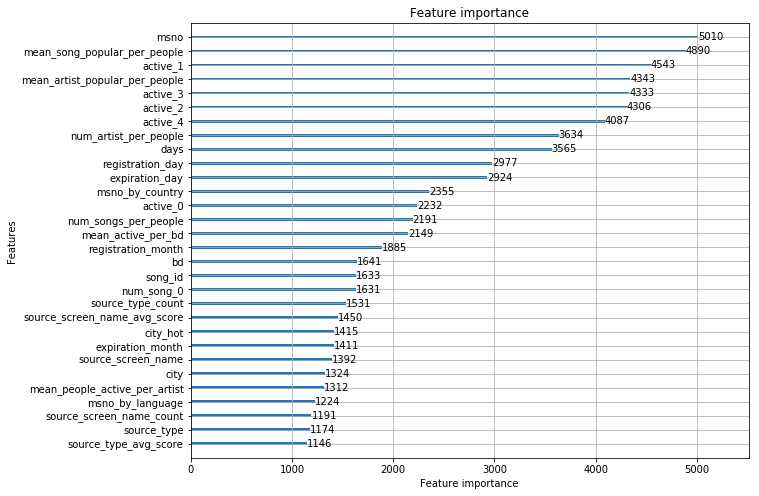

In [53]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=30)
plt.show()
# last 400 0.696958 800 0.703245

In [ ]:
float32_list = list()
for col in test.columns:
    if col not in ['song_length', 'id']:
        if test[col].dtype == np.float32:
            float32_list.append(col)
print(float32_list)

In [ ]:
def sum_merge_and_drop(train_data, val_data, test_data):
#     merge_columns = [('source_screen_name_mean_popular_0', 'source_screen_name_mean_popular_1', 'source_screen_name_mean_active_0', 'source_screen_name_mean_active_1'),\
#                     ('source_type_mean_popular_0', 'source_type_mean_popular_1', 'source_type_mean_active_0', 'source_type_mean_active_1'),\
#                     ('source_system_tab_mean_popular_0', 'source_system_tab_mean_popular_1', 'source_system_tab_mean_active_0', 'source_system_tab_mean_active_1')]

#     merge_columns_name = ['source_screen_name_avg_score', 'source_type_avg_score', 'source_system_tab_avg_score']
    
    merge_columns = [('source_screen_name_mean_popular_0', 'source_screen_name_mean_popular_1', 'source_screen_name_mean_active_0', 'source_screen_name_mean_active_1'),\
                    ('source_type_mean_popular_0', 'source_type_mean_popular_1', 'source_type_mean_active_0', 'source_type_mean_active_1'),\
                    ('source_system_tab_mean_popular_0', 'source_system_tab_mean_popular_1', 'source_system_tab_mean_active_0', 'source_system_tab_mean_active_1'),\
                    ('composer_by_city', 'composer_by_country', 'composer_by_language'),\
                    ('lyricist_by_city', 'lyricist_by_country', 'lyricist_by_language'),\
                    ('artist_name_by_city', 'artist_name_by_country', 'artist_name_by_language'),\
                    ('city_by_song_id', 'city_by_msno', 'city_by_genre_ids', 'city_by_artist_name'),\
                    ('language_by_song_id', 'language_by_msno', 'language_by_genre_ids', 'language_by_artist_name'),\
                    ('num_song_1', 'num_song_2', 'num_song_3', 'num_song_4'),\
                    ('num_people_1', 'num_people_2', 'num_people_3', 'num_people_4')]

    merge_columns_name = ['source_screen_name_avg_score',\
                        'source_type_avg_score',\
                        'source_system_tab_avg_score',\
                        'composer_by_city_country_language',\
                        'lyricist_by_city_country_language',\
                        'artist_name_by_city_country_language',\
                        'city_hot',\
                        'language_hot'\
                        'num_song_sum',\
                        'num_people_sum']
    
    for i, cols in enumerate(merge_columns):
        train_data[merge_columns_name[i]] = train_data[[col for col in cols]].mean(axis = 1).astype(np.float32)
        train_data.drop([col for col in cols], axis = 1, inplace=True)

        val_data[merge_columns_name[i]] = val_data[[col for col in cols]].mean(axis = 1).astype(np.float32)
        val_data.drop([col for col in cols], axis = 1, inplace=True)

        test_data[merge_columns_name[i]] = test_data[[col for col in cols]].mean(axis = 1).astype(np.float32)
        test_data.drop([col for col in cols], axis = 1, inplace=True)

    return train_data, val_data, test_data
train_use, validation_use, test = sum_merge_and_drop(train_use, validation_use, test)
gc.collect()

In [ ]:
#pd.read_csv(DATASET_PATH+'submission_2017-11-06 22:25:54.csv')#'submission_2017-11-07 17:29:32.csv')

In [ ]:
def param_tune_with_val(params, tune_param, param_list, data_list, val_data, less_prefered = False):
    #data_list = {'train':{'x':train_d,'y':train_y}, 'validation':{'x':valid_d,'y':valid_y}}
    best_metric = (less_prefered and sys.float_info.max or -sys.float_info.max)
    best_param = param_list[0]

    for par_value in param_list:
        params[tune_param] = par_value
        # , num_boost_round=params['num_boost_round'], early_stopping_rounds = params['early_stopping_rounds']
        model = lgb.train(params, data_list['train']['x'], valid_sets=[data_list['validation']['x']], \
                feature_name='auto', #categorical_feature=['source_system_tab', 'source_screen_name', 'source_type', 'city', 'gender',\
                                     #                       'bd', 'name', 'artist_name', 'composer', 'lyricist', 'msno', 'song_id', 'genre_ids',\
                                     #                       'country', 'language', 'registered_via'],、
                        )
       
        val_predprob = model.predict(val_data)
        auroc_score = metrics.roc_auc_score(data_list['validation']['y'], val_predprob)

        if (not less_prefered and auroc_score > best_metric) or (less_prefered and auroc_score < best_metric):
            best_metric = auroc_score
            best_param = par_value
    log.info('best param for {}: {}, metric: {}'.format(tune_param, best_param, best_metric))
    return best_param

In [ ]:
#{'top_k': 20, 'feature_fraction': 0.8, 'bagging_freq': 1, 'min_data_in_bin': 3, 'min_sum_hessian_in_leaf': 0.001, 'bagging_fraction': 0.9, 'max_depth': 12, 'num_leaves': 100, 'learning_rate': 0.01, 'objective': 'binary', 'lambda_l2': 0.01, 'feature_fraction_seed': 1024, 'min_data_in_leaf': 15, 'max_bin': 100, 'verbose': 0, 'bagging_seed': 6666, 'max_cat_to_onehot': 4, 'metric': 'auc', 'lambda_l1': 1e-05, 'num_threads': 16, 'boosting': 'gbdt', 'min_split_gain': 0.3}

#{'bagging_seed': 6666, 'lambda_l1': 1e-05, 'lambda_l2': 0.01, 'metric': 'auc', 'bagging_freq': 1, 'min_sum_hessian_in_leaf': 0.001, 'feature_fraction': 0.8, 'feature_fraction_seed': 1024, 'num_leaves': 90, 'boosting': 'gbdt', 'verbose': 0, 'min_data_in_leaf': 15, 'top_k': 20, 'objective': 'binary', 'min_data_in_bin': 3, 'num_threads': 16, 'max_cat_to_onehot': 4, 'max_depth': 10, 'bagging_fraction': 0.9, 'learning_rate': 0.01, 'max_bin': 80, 'min_split_gain': 0.3}

In [ ]:
def search_for_best_params(train, validation, test):
    
    X_train = lgb.Dataset(np.array(train.drop(['target'], axis=1)), label=train['target'].values)
    X_valid = lgb.Dataset(np.array(validation.drop(['target'], axis=1)), label=validation['target'].values)
    
    y_train = train['target'].values
    y_valid = validation['target'].values

    X_test = np.array(test.drop(['id'], axis=1))

    data_list = {'train':{'x':X_train,'y':y_train}, 'validation':{'x':X_valid,'y':y_valid}}
######## for value rather than catogory ################
#   params_to_eval = OrderedDict(
#         ( 
#         ('num_boost_round', range(120,150,10)),
#         ('num_leaves', range(80,100,10)), # number of leaves in one tree
#         ('max_depth', range(8,12,1)),
#         ('min_data_in_leaf', 15),
#         ('min_sum_hessian_in_leaf', [0.001]),# too high will lead to under-fitting
#         ('min_split_gain',[0.3]),# the minimum loss reduction required to make a split
#         ('bagging_fraction',[0.9]),# [i/10.0 for i in range(6,10)]
#         ('feature_fraction',[0.8]),# typical: 0.5-1
#         ('max_bin', range(70,90,10)),
#         ('lambda_l2',[0.01]),
#         ('lambda_l1',[1e-5]),
#         ('learning_rate',[0.01]), # typical: 0.01-0.2
#         )
#       )
     
#     initial_params = {
#         'objective': 'binary',
#         'boosting': 'gbdt',
#         'num_boost_round': 140,
#         'learning_rate': 0.01 ,
#         'verbose': 0,
#         'num_leaves': 90,
#         'num_threads':16,
#         'max_depth': 9,
#         'min_data_in_leaf': 15, #minimal number of data in one leaf. Can be used to deal with over-fitting
#         'min_sum_hessian_in_leaf': 1e-3, #minimal sum hessian in one leaf. Like min_data_in_leaf, it can be used to deal with over-fitting
#         'feature_fraction': 0.8, #colsample_bytree
#         'feature_fraction_seed': 1024,
#         'bagging_fraction': 0.9, #subsample
#         'bagging_freq': 1, #frequency for bagging, 0 means disable bagging. k means will perform bagging at every k iteration
#         'bagging_seed': 6666,
#         'early_stopping_rounds':10,   
#         'lambda_l1': 1e-5, #L1 regularization
#         'lambda_l2': 0.01, #L2 regularization
#         'max_cat_to_onehot': 4, #when number of categories of one feature smaller than or equal to max_cat_to_onehot, one-vs-other split algorithm will be used
#         'top_k': 20, #set this to larger value for more accurate result, but it will slow down the training speed
#         'min_split_gain': 0.3, #the minimal gain to perform split
#         'max_bin': 70, #max number of bins that feature values will be bucketed in. Small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)
#         'min_data_in_bin': 3, #min number of data inside one bin, use this to avoid one-data-one-bin (may over-fitting)       
#         'metric' : 'auc',
#     } 
    params_to_eval = OrderedDict(
        ( 
        ('num_boost_round', range(100,400,50)),
        ('num_leaves', range(80,160,10)), # number of leaves in one tree
        ('max_depth', range(8,18,1)),
        ('min_data_in_leaf', range(10,18,2)),
        ('min_sum_hessian_in_leaf', [0.001]),# too high will lead to under-fitting
        ('min_split_gain',[0.3]),# the minimum loss reduction required to make a split
        ('bagging_fraction',[0.9]),# [i/10.0 for i in range(6,10)]
        ('feature_fraction',[0.8]),# typical: 0.5-1
        ('max_bin', range(80,200,10)),
        ('lambda_l2',[0.01]),
        ('lambda_l1',[1e-5]),
        ('learning_rate',[0.01]), # typical: 0.01-0.2
        )
      )
     
    initial_params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'num_boost_round': 200,
        'learning_rate': 0.1 ,
        'verbose': 0,
        'num_leaves': 120,
        'num_threads':16,
        'max_depth': 14,
        'min_data_in_leaf': 16, #minimal number of data in one leaf. Can be used to deal with over-fitting
        'min_sum_hessian_in_leaf': 1e-3, #minimal sum hessian in one leaf. Like min_data_in_leaf, it can be used to deal with over-fitting
        'feature_fraction': 0.8, #colsample_bytree
        'feature_fraction_seed': 1024,
        'bagging_fraction': 0.9, #subsample
        'bagging_freq': 1, #frequency for bagging, 0 means disable bagging. k means will perform bagging at every k iteration
        'bagging_seed': 6666,
        'early_stopping_rounds':10,   
        'lambda_l1': 1e-5, #L1 regularization
        'lambda_l2': 0.01, #L2 regularization
        'max_cat_to_onehot': 4, #when number of categories of one feature smaller than or equal to max_cat_to_onehot, one-vs-other split algorithm will be used
        'top_k': 20, #set this to larger value for more accurate result, but it will slow down the training speed
        'min_split_gain': 0.3, #the minimal gain to perform split
        'max_bin': 140, #max number of bins that feature values will be bucketed in. Small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)
        'min_data_in_bin': 3, #min number of data inside one bin, use this to avoid one-data-one-bin (may over-fitting)       
        'metric' : 'auc',
    } 
    # only param nin this list are tuned, total list are ['n_estimators', 'reg_alpha', 'reg_lambda', 'subsample', 'colsample_bytree', 'min_child_weight', 'max_depth', 'learning_rate', 'gamma']
    #tuned_param_name = ['num_boost_round', 'num_leaves', 'max_depth', 'max_bin']
    tuned_param_name = ['num_boost_round', 'num_leaves', 'max_depth', 'min_data_in_leaf', 'min_sum_hessian_in_leaf',\
                        'min_split_gain', 'bagging_fraction', 'feature_fraction', 'max_bin', 'lambda_l2', 'lambda_l1', 'learning_rate']
    for par_name, par_list in params_to_eval.items():
        if par_name in tuned_param_name:
            log.info('tunning {}...'.format(par_name))
            if len(par_list) > 1:
                initial_params[par_name] = param_tune_with_val(initial_params, par_name, par_list, data_list, np.array(validation.drop(['target'], axis=1)))
            else:
                initial_params[par_name] = par_list[0]
    
    return initial_params

In [ ]:
start_time = time.time()
best_param = search_for_best_params(train_use, validation_use, test)
log.info(best_param)
time_elapsed = time.time() - start_time
log.info('time used: {:.3f}sec'.format(time_elapsed))

In [ ]:
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'num_boost_round': 140,
        'learning_rate': 0.01 ,
        'verbose': 0,
        'num_leaves': 90,
        'num_threads':16,
        'max_depth': 9,
        'min_data_in_leaf': 15, #minimal number of data in one leaf. Can be used to deal with over-fitting
        'min_sum_hessian_in_leaf': 1e-3, #minimal sum hessian in one leaf. Like min_data_in_leaf, it can be used to deal with over-fitting
        'feature_fraction': 0.8, #colsample_bytree
        'feature_fraction_seed': 1024,
        'bagging_fraction': 0.9, #subsample
        'bagging_freq': 1, #frequency for bagging, 0 means disable bagging. k means will perform bagging at every k iteration
        'bagging_seed': 6666,
        'early_stopping_rounds':10,   
        'lambda_l1': 1e-5, #L1 regularization
        'lambda_l2': 0.01, #L2 regularization
        'max_cat_to_onehot': 4, #when number of categories of one feature smaller than or equal to max_cat_to_onehot, one-vs-other split algorithm will be used
        'top_k': 20, #set this to larger value for more accurate result, but it will slow down the training speed
        'min_split_gain': 0.3, #the minimal gain to perform split
        'max_bin': 70, #max number of bins that feature values will be bucketed in. Small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)
        'min_data_in_bin': 3, #min number of data inside one bin, use this to avoid one-data-one-bin (may over-fitting)       
        'metric' : 'auc',
    } 
X_train = lgb.Dataset(np.array(train_use.drop(['target'], axis=1)), label=train_use['target'].values)
X_valid = lgb.Dataset(np.array(validation_use.drop(['target'], axis=1)), label=validation_use['target'].values)
X_test = np.array(test.drop(['id'], axis=1))
model = lgb.train(params, X_train, valid_sets=[X_valid])
pred = model.predict(X_test)

submission = pd.DataFrame({'id': test_id, 'target': pred})
submission.to_csv(SUBMISSION_FILENAME.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')),index=False)


In [ ]:
X_train = np.array(train_use.drop(['target'], axis=1))
y_train = train_use['target'].values

X_valid = np.array(validation_use.drop(['target'], axis=1))
y_valid = validation_use['target'].values

X_test = np.array(test.drop(['id'], axis=1))

# d_train = xgb.DMatrix(X_train)
# d_valid = xgb.DMatrix(X_valid) 
# d_test = xgb.DMatrix(X_test)

data_list = {'train':{'x':X_train,'y':y_train}, 'validation':{'x':X_valid,'y':y_valid}}
# Train model, evaluate and make predictions
params={
    'n_estimators':500,
    'objective': 'binary:logistic',
    'learning_rate': 0.75,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':16,
    'seed':1024,
    }

param_tune_with_val(params, 'max_depth', [5,1,6], data_list, 'auc', 20)

# model = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=20, \
#     maximize=True, verbose_eval=5)



In [ ]:
X_train = np.array(train_use.drop(['target'], axis=1))
y_train = train_use['target'].values

X_valid = np.array(validation_use.drop(['target'], axis=1))
y_valid = validation_use['target'].values

X_test = np.array(test.drop(['id'], axis=1))

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid) 
d_test = xgb.DMatrix(X_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

# Train model, evaluate and make predictions
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.75
params['max_depth'] = 16
params['silent'] = 1
params['eval_metric'] = 'auc'

model = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=20, \
    maximize=True, verbose_eval=5)

#Predict training set:
train_predictions = model.predict(X_train)
train_predprob = model.predict_proba(X_train)[:,1]

val_predictions = model.predict(X_valid)
val_predprob = model.predict_proba(X_valid)[:,1]

#Print model report:
print("\nModel Report")
print("Train Accuracy : %.4g" % metrics.accuracy_score(y_train, train_predictions))
print("Train AUC Score (Train): %f" % metrics.roc_auc_score(y_train, train_predprob))
print("ValAccuracy : %.4g" % metrics.accuracy_score(y_valid, val_predictions))
print("Validation AUC Score (Train): %f" % metrics.roc_auc_score(y_valid, val_predprob))

feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

p_test = model.predict(d_test)

In [ ]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, train_use.drop(['target'],axis=1), train_use['target'], validation_use.drop(['target'],axis=1), validation_use['target'])

In [ ]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
def modelfit(alg, train, label, validation, val_label, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train.values, label=label.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train, label, eval_metric='auc')
        
    #Predict training set:
    train_predictions = alg.predict(train)
    train_predprob = alg.predict_proba(train)[:,1]
    
    val_predictions = alg.predict(validation)
    val_predprob = alg.predict_proba(validation)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Train Accuracy : %.4g" % metrics.accuracy_score(label.values, train_predictions))
    print("Train AUC Score (Train): %f" % metrics.roc_auc_score(label, train_predprob))
    print("ValAccuracy : %.4g" % metrics.accuracy_score(val_label.values, val_predictions))
    print("Validation AUC Score (Train): %f" % metrics.roc_auc_score(val_label, val_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
########################################
## import packages
########################################

import datetime
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Reshape
from keras.layers.merge import concatenate, dot
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD

########################################
## load the data
########################################

train = pd.read_csv('./data/train.csv')
uid = train.msno
sid = train.song_id
target = train.target

test = pd.read_csv('./data/test.csv')
id_test = test.id
uid_test = test.msno
sid_test = test.song_id

########################################
## encoding
########################################

usr_encoder = LabelEncoder()
usr_encoder.fit(uid.append(uid_test))
uid = usr_encoder.transform(uid)
uid_test = usr_encoder.transform(uid_test)

sid_encoder = LabelEncoder()
sid_encoder.fit(sid.append(sid_test))
sid = sid_encoder.transform(sid)
sid_test = sid_encoder.transform(sid_test)

u_cnt = int(max(uid.max(), uid_test.max()) + 1)
s_cnt = int(max(sid.max(), sid_test.max()) + 1)

########################################
## train-validation split
########################################

perm = np.random.permutation(len(train))
trn_cnt = int(len(train) * 0.85)
uid_trn = uid[perm[:trn_cnt]]
uid_val = uid[perm[trn_cnt:]]
sid_trn = sid[perm[:trn_cnt]]
sid_val = sid[perm[trn_cnt:]]
target_trn = target[perm[:trn_cnt]]
target_val = target[perm[trn_cnt:]]

########################################
## define the model
########################################

def get_model():
    user_embeddings = Embedding(u_cnt,
            64,
            embeddings_initializer=RandomUniform(minval=-0.1, maxval=0.1),
            embeddings_regularizer=l2(1e-4),
            input_length=1,
            trainable=True)
    song_embeddings = Embedding(s_cnt,
            64,
            embeddings_initializer=RandomUniform(minval=-0.1, maxval=0.1),
            embeddings_regularizer=l2(1e-4),
            input_length=1,
            trainable=True)

    uid_input = Input(shape=(1,), dtype='int32')
    embedded_usr = user_embeddings(uid_input)
    embedded_usr = Reshape((64,))(embedded_usr)

    sid_input = Input(shape=(1,), dtype='int32')
    embedded_song = song_embeddings(sid_input)
    embedded_song = Reshape((64,))(embedded_song)

    preds = dot([embedded_usr, embedded_song], axes=1)
    preds = concatenate([embedded_usr, embedded_song, preds])
    
    preds = Dense(128, activation='relu')(preds)
    preds = Dropout(0.5)(preds)
    
    preds = Dense(1, activation='sigmoid')(preds)

    model = Model(inputs=[uid_input, sid_input], outputs=preds)
    
    opt = RMSprop(lr=1e-3)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

    return model

########################################
## train the model
########################################
   
model = get_model()
early_stopping =EarlyStopping(monitor='val_acc', patience=5)
model_path = 'bst_model.h5'
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, \
        save_weights_only=True)

hist = model.fit([uid_trn, sid_trn], target_trn, validation_data=([uid_val, sid_val], \
        target_val), epochs=100, batch_size=32768, shuffle=True, \
        callbacks=[early_stopping, model_checkpoint])
model.load_weights(model_path)

preds_val = model.predict([uid_val, sid_val], batch_size=32768)
val_auc = roc_auc_score(target_val, preds_val)

########################################
## make the submission
########################################

preds_test = model.predict([uid_test, sid_test], batch_size=32768, verbose=1)
sub = pd.DataFrame({'id': id_test, 'target': preds_test.ravel()})
sub.to_csv('./sub_%.5f.csv'%(val_auc), index=False)

In [ ]:
# Linear algebra:
import numpy as np
import pandas as pd
# Graphics:
import matplotlib.pyplot as plt
import seaborn as sns  
# Frameworks:
import lightgbm as lgb # LightGBM
# Utils:
import gc # garbage collector
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

IDIR = '../input/' # main path
members = pd.read_csv(IDIR + 'members.csv')
songs = pd.read_csv(IDIR + 'songs.csv')
song_extra_info = pd.read_csv(IDIR + 'song_extra_info.csv')
train = pd.read_csv(IDIR + 'train.csv')
test = pd.read_csv(IDIR + 'test.csv')

# Adding songs' info:
train_aug1 = pd.merge(left=train, right=songs, on='song_id', how='left')
test_aug1 = pd.merge(left=test, right=songs, on='song_id', how='left')
# Adding extra info about songs:
train_aug2 = pd.merge(left=train_aug1, right=song_extra_info, on='song_id', how='left')
test_aug2 = pd.merge(left=test_aug1, right=song_extra_info, on='song_id', how='left')
del train_aug1, test_aug1
# Addind users' info:
train_aug3 = pd.merge(left=train_aug2, right=members, on='msno', how='left')
test_aug3 = pd.merge(left=test_aug2, right=members, on='msno', how='left')
del train_aug2, test_aug2
# Merging train and test data:
train_aug3.drop(['song_id'], axis=1, inplace=True)
train_aug3['set'] = 0
test_aug3.drop(['song_id'], axis=1, inplace=True)
test_aug3['set'] = 1
test_aug3['target'] = -1
all_aug = pd.concat([train_aug3, test_aug3], axis=0)
del train_aug3, test_aug3
gc.collect();



# source_system_tab/source_screen_name/source_type/genre_ids/artist_name/composer/lyricist/name/isrc/gender 用'NA'填补并one-hot编码
# genre_ids encoding:
all_aug['genre_ids'] = all_aug.genre_ids.fillna('NA')
all_aug['genre_ids'] = all_aug.genre_ids.astype(np.str)
genre_ids_le = LabelEncoder()
genre_ids_le.fit(all_aug.genre_ids)
all_aug['genre_ids'] = genre_ids_le.transform(all_aug.genre_ids).astype(np.int16)

# language encoding:
all_aug['language'] = all_aug.language.fillna(-2)
all_aug['language'] = all_aug.language.astype(np.int8)

# city encoding:
all_aug['city'] = all_aug.city.astype(np.int8)
# bd encoding:
all_aug['bd'] = all_aug.bd.astype(np.int16)

# registered_via encoding:
all_aug['registered_via'] = all_aug.registered_via.astype(np.int8)
# registration_init_time encoding:
all_aug['registration_init_time'] = all_aug.registration_init_time.astype(np.int32)
# expiration_date encoding:
all_aug['expiration_date'] = all_aug.expiration_date.astype(np.int32)
# Info:
all_aug.info(max_cols=0)
all_aug.head(2)


all_aug['exp_reg_time'] = all_aug.expiration_date - all_aug.registration_init_time



gc.collect();
d_train = lgb.Dataset(all_aug[all_aug.set == 0].drop(['target', 'msno', 'id', 'set'], axis=1), 
                      label=all_aug[all_aug.set == 0].pop('target'))
ids_train = all_aug[all_aug.set == 0].pop('msno')

lgb_params = {
    'learning_rate': 1.0,
    'max_depth': 15,
    'num_leaves': 250, 
    'objective': 'binary',
    'metric': {'auc'},
    'feature_fraction': 0.8,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'max_bin': 100}
cv_result_lgb = lgb.cv(lgb_params, 
                       d_train, 
                       num_boost_round=5000, 
                       nfold=3, 
                       stratified=True, 
                       early_stopping_rounds=50, 
                       verbose_eval=100, 
                       show_stdv=True)

num_boost_rounds_lgb = len(cv_result_lgb['auc-mean'])
print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))



%%time
ROUNDS = num_boost_rounds_lgb
print('light GBM train :-)')
bst = lgb.train(lgb_params, d_train, ROUNDS)
# lgb.plot_importance(bst, figsize=(9,20))
# del d_train
gc.collect()


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
feature_imp = pd.Series(dict(zip(d_train.feature_name, 
                                 bst.feature_importance()))).sort_values(ascending=False)
sns.barplot(x=feature_imp.values, y=feature_imp.index.values, orient='h', color='g')
plt.subplot(1,2,2)
train_scores = np.array(cv_result_lgb['auc-mean'])
train_stds = np.array(cv_result_lgb['auc-stdv'])
plt.plot(train_scores, color='green')
plt.fill_between(range(len(cv_result_lgb['auc-mean'])), 
                 train_scores - train_stds, train_scores + train_stds, 
                 alpha=0.1, color='green')
plt.title('LightGMB CV-results')
plt.show()